# Introdução:

A ideia deste _notebook_ é entender como Python pode ser usado para análise de dados financeiros (em particular, dados de ações), implementar um algoritmo de LSTM para tentar fazer previsões em cima dos dados e ver como se saem essas previsões. 



# Preliminares:
Começamos importando as bibliotecas a serem usadas, bem como os dados.

Os dados, em arquivo `.csv`, foram obtidos da página: `https://www.infomoney.com.br/cotacoes/b3/bdr/nubank-nubr33/historico/`

PS: Ao iniciar este _notebook_, eu ainda não sabia que poderia usar `yfinance` para importar dados melhor formatados e atualizados. Entretanto, trabalhar com este `.csv` foi bom para praticar o pré-processamento de dados, e por este motivo não fiz alterações neste sentido. 

In [2]:
import datetime
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
from   tensorflow.keras.models     import Sequential
from   tensorflow.keras.optimizers import Adam
from   tensorflow.keras            import layers

# preparando a  exibição gráfica:
%matplotlib inline
sns.set()           

# importando os dados:
nubank = pd.read_csv('nubr33.csv')

#---------#    alternativamente:    #-----------------# 
#-----------------------------------------------------#
# import yfinance as yf                               #
# t0 = pd.to_datetime('2023-01-01')                   #
# t1 = pd.to_datetime('now')                          #
# nubank = yf.download('NUBR33.SA', start=t0, end=t1) #
#-----------------------------------------------------#

nubank

,DATA,ABERTURA,FECHAMENTO,VARIAÇÃO,MÍNIMO,MÁXIMO,VOLUME
0,10/07/2023,"6,27","6,40","2,07","6,26","6,40","7,06M"
1,07/07/2023,"6,31","6,27","-0,63","6,24","6,39","4,95M"
2,06/07/2023,"6,40","6,31","-1,41","6,19","6,41","11,26M"
3,05/07/2023,"6,38","6,40","0,00","6,27","6,42","8,64M"
4,04/07/2023,"6,30","6,40","0,63","6,30","6,41","1,89M"
...,...,...,...,...,...,...,...
375,07/01/2022,"8,60","8,66","-3,67","8,57","9,07","13,21M"
376,06/01/2022,"8,65","8,99","5,15","8,05","8,99","20,04M"
377,05/01/2022,"9,02","8,55","-6,86","8,48","9,23","25,92M"
378,04/01/2022,"9,32","9,18","-1,29","8,92","9,70","23,31M"


In [3]:
# formata a string se livrando de vírgulas e convertendo as unidades de medida (K e M);
# converte string para numpy.float64;
def string_to_num(x):
  if x == "n/d":
    return np.nan
  elif x[-3] == ",":
    return np.float64(x[:-3]+"."+x[-2:])
  elif x[-4] == ",":
    if (x[-1] == "K"):
      return np.float64(x[:-4]+"."+x[-3:-1]) * (10**3)
    elif (x[-1] == "M"):
      return (np.float64(x[:-4]+"."+x[-3:-1]))*(10**6)


# Pré-Processamento de dados

Verificamos se não há dados nulos e então renomeamos as colunas para nomes mais convenientes, nos livrando de letras maiúsculas e de caracteres indesejados.

Depois, formatamos e convertemos a data para um tipo mais adequado, organizamos as linhas em ordem cronológica e definimos a coluna de data como índice.

Os dados das colunas de `'ABERTURA'` até `'VOLUME'` são do tipo `str`, e a conversão para `numpy.float64` é inevitável, já que necessitamos efetuar cálculos sobre estes valores.  

In [ ]:
nubank.info()

In [4]:
# renomeando as colunas:
nubank.rename(columns = {'VARIAÇÃO':'variacao', 'MÍNIMO':'min', 'MÁXIMO':'max'}, inplace=True)
nubank.columns = nubank.columns.str.lower()

# formatando e convertendo a data:
nubank['data'] = nubank['data'].apply(lambda x: x[-4:] + "-" + x[3:5] + "-" + x[0:2])
nubank['data'] = pd.to_datetime(nubank['data'])

# reindexando e reordenando o dataframe:
nubank.set_index('data', inplace=True)
nubank.sort_index(ascending=True, inplace=True)

# convertendo os dados das colunas de 'abertura' até 'max'
for column in nubank.columns[:]:
  nubank[column] = nubank[column].apply(string_to_num)

#------#
nubank # dataset após o pré-processamento.
#------#

,abertura,fechamento,variacao,min,max,volume
data,,,,,,
2022-01-03,8.78,9.30,6.16,8.78,9.40,22140000.0
2022-01-04,9.32,9.18,-1.29,8.92,9.70,23310000.0
2022-01-05,9.02,8.55,-6.86,8.48,9.23,25920000.0
2022-01-06,8.65,8.99,5.15,8.05,8.99,20040000.0
2022-01-07,8.60,8.66,-3.67,8.57,9.07,13210000.0
...,...,...,...,...,...,...
2023-07-04,6.30,6.40,0.63,6.30,6.41,1890000.0
2023-07-05,6.38,6.40,0.00,6.27,6.42,8640000.0
2023-07-06,6.40,6.31,-1.41,6.19,6.41,11260000.0


# Análise
Agora, podemos começar a investigar melhor os dados. Iniciamos olhando para os dados referentes ao presente ano (2023).

In [5]:
ano2023 = (nubank.index >= '2023')
nubank[ano2023].describe()

,abertura,fechamento,variacao,min,max,volume
count,130.000000,130.000000,130.000000,130.000000,130.000000,1.300000e+02
mean,4.478154,4.499923,0.508846,4.391308,4.601231,2.086638e+07
std,0.998024,1.008293,3.027867,0.988902,1.007719,1.435641e+07
min,3.050000,3.040000,-8.440000,2.970000,3.100000,1.890000e+06
25%,3.770000,3.772500,-1.287500,3.700000,3.892500,1.099250e+07
50%,4.160000,4.195000,0.545000,4.065000,4.255000,1.675000e+07
75%,5.547500,5.600000,2.195000,5.422500,5.645000,2.748750e+07
max,6.400000,6.400000,10.360000,6.300000,6.420000,7.827000e+07


Vemos que a média de ```fechamento``` é ligeiramente maior do que a média de ```abertura```, e que a média de ```variacao``` é positiva, o que nos diz que as ações mais subiram do que desceram no ano de 2023 até o momento. Abaixo, plotamos um gráfico para observar o comportamento da ação ao longo dos dias.

In [7]:
nubank.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 380 entries, 2022-01-03 to 2023-07-10
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   abertura    380 non-null    float64
 1   fechamento  380 non-null    float64
 2   variacao    380 non-null    float64
 3   min         380 non-null    float64
 4   max         380 non-null    float64
 5   volume      380 non-null    float64
dtypes: float64(6)
memory usage: 20.8 KB


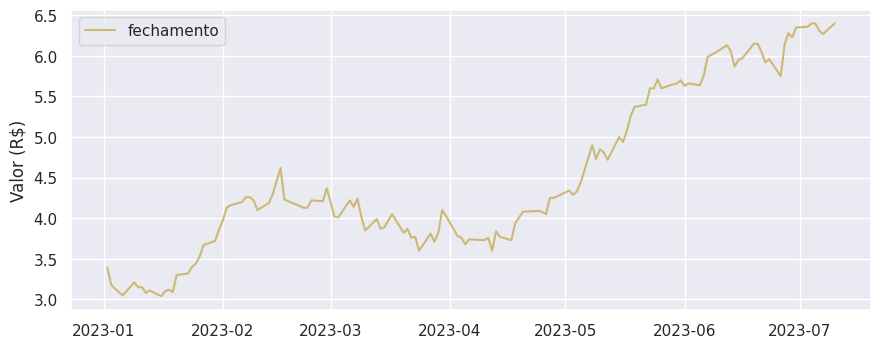

In [6]:
fig1 = plt.figure(figsize=(8,3), dpi=100)

axes1 = fig1.add_axes([0, 0, 1, 1])
axes1.plot(nubank[ano2023]['fechamento'], 'y', label='fechamento')
axes1.set_ylabel('Valor (R$)')
axes1.legend(loc=0)

# Média Móvel

A crescente no período analisado é visível. Para melhor entendê-la, calculamos a média móvel dos valores de fechamento para períodos de 6, 28 e 64 dias, e as introduzimos como colunas em nosso dataframe:

In [ ]:
nubank['mm6']   =  nubank['fechamento'].rolling(window=6).mean()
nubank['mm28']  =  nubank['fechamento'].rolling(window=28).mean()
nubank['mm64']  =  nubank['fechamento'].rolling(window=64).mean()
nubank[ano2023]

In [ ]:
fig = plt.figure(figsize=(5,4), dpi=100)
ax  = fig.add_axes([0.1, 0.1, 1.6, 1])

ax.plot(nubank[ano2023]['mm6'])
ax.plot(nubank[ano2023]['mm28'])
ax.plot(nubank[ano2023]['mm64'])
ax.plot(nubank[ano2023]['fechamento'])
ax.legend(['mm6','mm28','mm64','fechamento'])

#Previsão LSTM:


Vamos, inicialmente, tentar fazer uma previsão simples para o valor de fechamento. Para isso, consideramos apenas a seguinte coluna:

In [ ]:
fechamento =  nubank['fechamento']
fig        =  plt.figure(figsize=(14,8), dpi=100)

plt.plot(fechamento)

E agora construímos uma função para gerar uma tabela com alvos por data:

In [ ]:
def df_alvos(df, n):

  '''
  Recebe um dataframe de uma coluna indexada por datas
  e retorna um dataframe cujas linhas são compostas
  por uma data, seguida pelos n valores anteriores à data e,
  por fim, o valor referente à data que inicia a linha.
  '''

  df = df.reset_index()

  nomes = ['data_alvo']
  for i in range(1, n+1):
    nomes.append("x_"+str(n-i+1))
  nomes.append('alvo')

  novo_df=[]
  for i in range(n, len(df)):
    novo_df.append([df[df.columns[0]][i]])
    for j in range(0, n+1):
      novo_df[i-n].append(df[df.columns[1]][i-(n-j)])

  return pd.DataFrame(novo_df, columns=nomes)


In [ ]:
pred = 7

df_alvos(fechamento, pred)

Agora, separamos os alvos das datas, e os transformamos:

In [ ]:
def df_alvos_separados(alvos):
  '''
  Separa o dataframe de alvos em um numpy.ndarray
  de datas, um de variáveis ind
  '''
  alvos_np = alvos.to_numpy()

  datas = alvos_np[:, 0]
  Y = alvos_np[:, -1]

  meiuca = alvos_np[:, 1:-1]
  X = meiuca.reshape((len(datas), meiuca.shape[1], 1))

  return datas, X.astype(np.float32), Y.astype(np.float32)

In [ ]:
datas, x, y = df_alvos_separados(df_alvos(fechamento, pred))

In [ ]:
q_80 = int(len(datas)*0.8)
q_90 = int(len(datas)*0.9)

datas_treino, x_treino, y_treino = datas[:q_80],     x[:q_80],     y[:q_80]
datas_val,    x_val,    y_val    = datas[q_80:q_90], x[q_80:q_90], y[q_80:q_90]
datas_teste,  x_teste,  y_teste  = datas[q_90:],     x[q_90:],     y[q_90:]

Agora, podemos visualizar os conjuntos de treino, teste e validação da nossa variável dependente y:

In [ ]:
fig = plt.figure(figsize=(5,4), dpi=100)

axe = fig.add_axes([0.1, 0.1, 1.6, 1])
axe.plot(datas_treino, y_treino)
axe.plot(datas_val, y_val)
axe.plot(datas_teste, y_teste)

In [ ]:
# aqui, nós criamos e treinamos a rede neural
model = Sequential([layers.Input((pred,1)),
                    layers.LSTM(128),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(x_treino, y_treino, validation_data=(x_val, y_val), epochs=128)

In [ ]:
train_predictions = model.predict(x_treino).flatten()


fig = plt.figure(figsize=(5,4), dpi=100)
axe = fig.add_axes([0.1, 0.1, 1.6, 1])

axe.plot(datas_treino, train_predictions)
axe.plot(datas_treino, y_treino)
axe.legend(['pedricoes de treino', 'observacoes de treino'])


In [ ]:
val_predictions = model.predict(x_val).flatten()


fig = plt.figure(figsize=(5,4), dpi=100)
axe = fig.add_axes([0.1, 0.1, 1.6, 1])

axe.plot(datas_val, val_predictions)
axe.plot(datas_val, y_val)
axe.legend(['pedricoes de validacao', 'observacoes de validacao'])

In [ ]:
test_predictions = model.predict(x_teste).flatten()


fig = plt.figure(figsize=(5,4), dpi=100)
axe = fig.add_axes([0.1, 0.1, 1.6, 1])

axe.plot(datas_teste, test_predictions)
axe.plot(datas_teste, y_teste)
axe.legend(['pedricoes de teste', 'observacoes de teste'])

In [ ]:
print("erro máximo:\t", np.max(abs(test_predictions - y_teste)))
print("erro médio:\t", np.mean(abs(test_predictions - y_teste)))

In [ ]:
from copy import deepcopy

predicao_recursiva = []
data_recursiva = np.concatenate([datas_val, datas_teste])

for target in data_recursiva:
  ultimo = deepcopy(x_treino[-1])
  proximo = model.predict(np.array([ultimo])).flatten()
  predicao_recursiva.append(proximo)
  ultimo[-1] = proximo

In [ ]:
fig = plt.figure(figsize=(5,4), dpi=100)
axe = fig.add_axes([0.1, 0.1, 2.8, 2])


axe.plot(datas_treino, train_predictions)
axe.plot(datas_treino, y_treino)
axe.plot(datas_val, val_predictions)
axe.plot(datas_val, y_val)
axe.plot(datas_teste, test_predictions)
axe.plot(datas_teste, y_teste)
axe.plot(data_recursiva, predicao_recursiva)
axe.legend(['predicao treino',
            'observação trein',
            'predicao validacao',
            'observvação validação',
            'predição teste',
            'observação teste',
            'predição recursiva'])

# Conclusão

Mais cuidados poderiam ser tomados ao implementar o modelo de LSTM, porém, observando que o modelo fez uma previsão de preços constantes de fechamento de uma ação, temos um forte indicativo de que o uso de LSTM não é uma alternativa viável para prever preços de ações. 